# Portafolios de Inversión
## Segundo Examen Parcial
José Armando Melchor Soto

---





### Liberías

In [387]:
import pandas as pd 
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize 

---

### Importación de datos

---

### Funciones 

##### Función Mínima Varianza 

In [388]:
def opt_min_var(rets):
    
    cov=rets.cov()
    n_assets = len(rets.columns)
    
    var = lambda w: w.T @ cov @ w
    
    w0=np.ones(n_assets)/n_assets
    
    bounds=[(0, 1)]*n_assets
    
    constraint=lambda w: sum(w)-1
    
    result=minimize(fun=var, x0=w0, bounds=bounds, constraints={'fun': constraint, 'type': 'eq'}, tol=1e-16)

    return dict(zip(rets.columns, result.x))

##### Función Máximo de Sharpe

In [389]:
def opt_max_sharpe(rets, rf):
    
    E=rets.mean()
    cov=rets.cov()
    n_assets = len(rets.columns)
    
    rs = lambda w: -((w.T @ E - rf/252) / np.sqrt(w.T @ cov @ w))
    
    w0=np.ones(n_assets)/n_assets
    
    bounds=[(0, 1)]*n_assets
    
    constraint=lambda w: sum(w)-1
    
    result=minimize(fun=rs, x0=w0, bounds=bounds, constraints={'fun': constraint, 'type': 'eq'}, tol=1e-16)
    
    return dict(zip(rets.columns, result.x))

##### Función Semi-Varianza Target

In [390]:
def objetivo (rets:pd.DataFrame , rets_b : pd.DataFrame ,corr:pd.DataFrame):
    
    rets, rets_b = rets.align(rets_b, join='inner', axis=0)
    diffs=rets - rets_b.values
    rends_below_bench = diffs[diffs < 0].fillna(0)
    target_downside_risk=np.array(rends_below_bench.std())
    target_semivarmatrix= corr * (target_downside_risk.reshape(len(rets.columns), 1) @ target_downside_risk.reshape(1, len(rets.columns)))

    objectivo = lambda w: (w.T @ target_semivarmatrix @ w)

    n = len(rets.keys())
    w_inicial = np.ones(n)/n
    bounds = [(0,1)]*n
    tol = 1e-9
    rest = lambda w: np.sum(w) - 1
    
    obj = minimize(
    fun=objectivo,
    x0=w_inicial,
    bounds=bounds,
    constraints={'fun': rest, 'type': 'eq'},
    tol=tol)

    w_objetivo = obj.x

    return dict(zip(rets.columns, w_objetivo))

##### Función Backtesting 

In [391]:
def backtesting(prices: pd.DataFrame, benchmark: pd.DataFrame, weights: dict, capital: float):
    
    rets_assets = prices.pct_change().dropna()
    rets_benchmark = benchmark.pct_change().dropna()
    
    df = pd.DataFrame(index=rets_assets.index)

    for strategy in weights.keys():
        if strategy == 'benchmark':
            temp = rets_benchmark + 1
            temp.iloc[0]=capital
            temp = temp.cumprod()
            df[strategy] = temp.values            

        else:
            temp = (rets_assets * weights.get(strategy)).sum(axis=1)+1
            temp.iloc[0]=capital
            temp = temp.cumprod()
            df[strategy] = temp.values    

    plt.figure(figsize=(12,6))
    plt.plot(df, label=df.keys())
    plt.title('Backtesting of Strategies')
    plt.xlabel('Date')
    plt.ylabel('Portafolio Value')
    plt.legend()
    plt.show()


    return df

##### Función Métricas de Desempeño

In [392]:
def metrics ( history , rf):
    # returns 
    rets = history.pct_change().dropna()
    # Cov 
    cov = rets.cov()
    # DataFrame
    df = pd.DataFrame(index=rets.columns)

    # Rendimientos
    df['Rendimiento'] =r_p= rets.mean()
    #volatilidad 
    df['Volatilidad'] =vol =rets.std()
    # Sharpe 
    df['Sharpe']= sharpe = (r_p - rf) /vol
    # Downside
    df['Downside']  = downside = rets[rets<0].std()
    # Upside 
    df['Upside'] = upside = rets[rets>0].std()
    # Omega
    df['Omega'] = omega = upside / downside
    # Beta
    cov_b = cov['Benchmark']
    var_b = cov_b['Benchmark']
    df['Beta'] = beta = cov_b / var_b

    #Alpha de Jensen 
    r_m = rets['Benchmark'].mean()
    df['Alpha'] = alpha = r_p - (rf + beta * (r_m - rf))

    # Sortino
    df['Sortino'] = (r_p -rf) /downside

    # Treynor
    df['Treynor'] = (r_p-rf)/beta

    return df.T


---

---

#### Pregunta 5

Asume que la acción de Tesla tiene un rendimiento anual promedio de 18%, con una Beta de 1.7. Si el rendimiento esperado del mercado es de 10% anual con una volatilidad del 5% y la tasa libre de riesgo se encuentra actualmente en 3%:

Según la teoría del CAPM, ¿La acción se encuentra sobrevalorada, subvaluada o correctamente valuada?
 

---

#### Pregunta 10

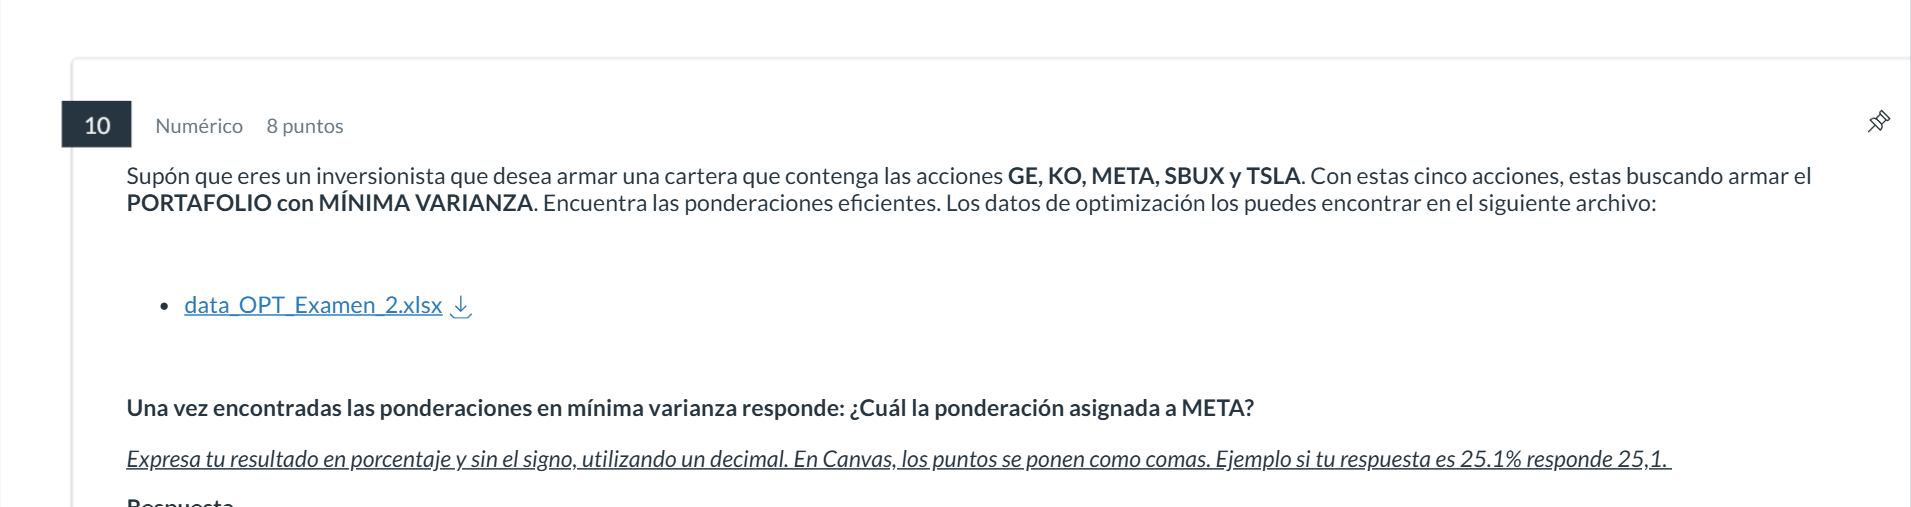

#### Importación de los datos

In [393]:
prices = pd.read_excel('data_OPT_Examen_2.xlsx', index_col=[0])
prices_bt = pd.read_excel('data_BT_Examen_2.xlsx', index_col=[0])


#### Portafolio 

### Seleccionar los activos GE , KO , META , SBUX , TSLA 

In [394]:
opt_prices = prices[['GE', 'KO', 'META', 'SBUX', 'TSLA']]
opt_prices.head()

,GE,KO,META,SBUX,TSLA
Date,,,,,
2019-01-02,47.434509,40.467045,135.679993,58.538540,20.674667
2019-01-03,47.493431,40.216984,131.740005,55.999321,20.024000
2019-01-04,48.495148,41.018909,137.949997,57.855946,21.179333
2019-01-07,51.500332,40.484291,138.050003,57.855946,22.330667
2019-01-08,50.439686,40.941296,142.529999,57.901459,22.356667


In [395]:
benchmark = prices[['^DJI']]
benchmark.head()

,^DJI
Date,
2019-01-02,23346.240234
2019-01-03,22686.220703
2019-01-04,23433.160156
2019-01-07,23531.349609
2019-01-08,23787.449219


In [396]:
rets = opt_prices.pct_change().dropna()
rets_b = benchmark.pct_change().dropna()
corr = rets.corr()

In [397]:
w_minvar = opt_min_var(rets)
w_minvar

{'GE': 0.0,
 'KO': 0.7108483815333237,
 'META': 0.21538677717493201,
 'SBUX': 0.06382551376931679,
 'TSLA': 0.009939327522427426}

---

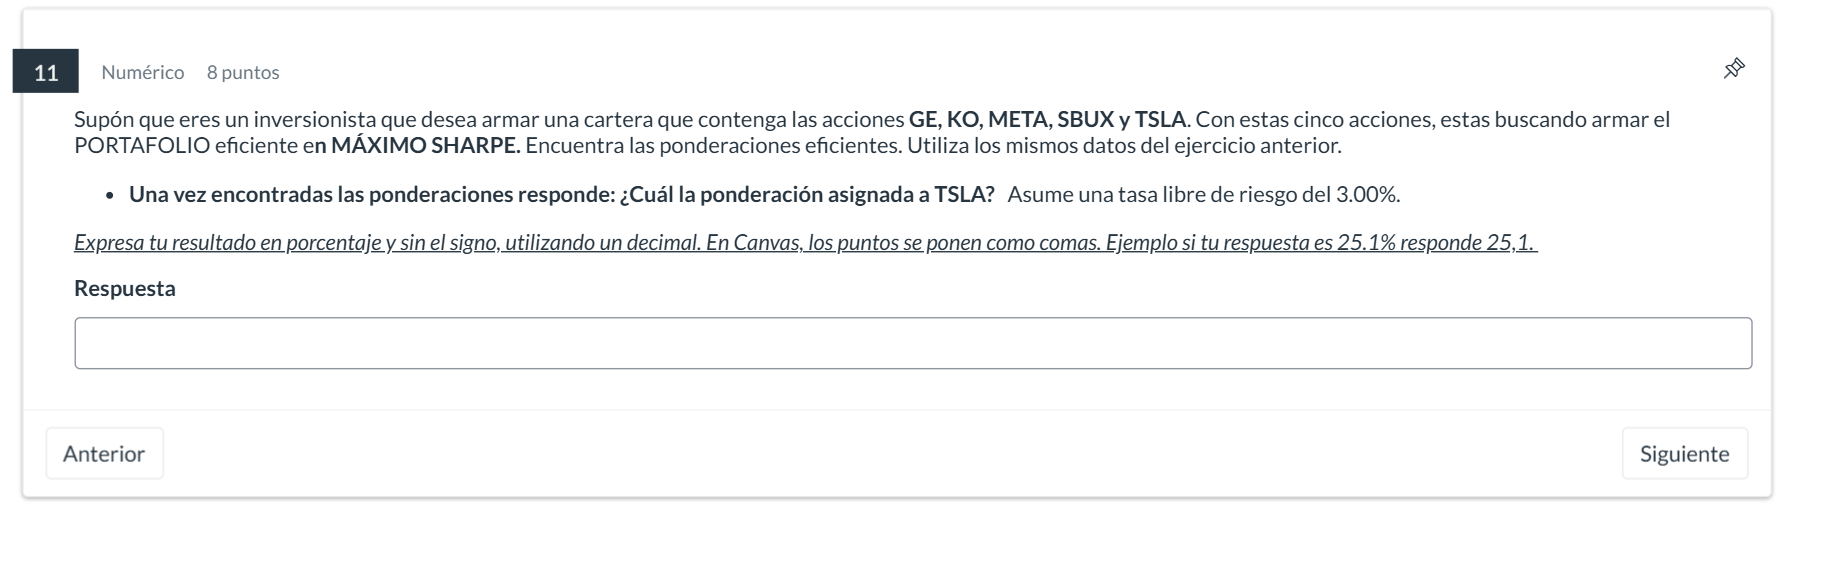

In [398]:
w_maxsharpe = opt_max_sharpe(rets, 0.03)
w_maxsharpe

{'GE': 0.0980313186790022,
 'KO': 8.318062065384242e-18,
 'META': 0.3665262192587426,
 'SBUX': 0.0,
 'TSLA': 0.5354424620622552}

---

#### 12

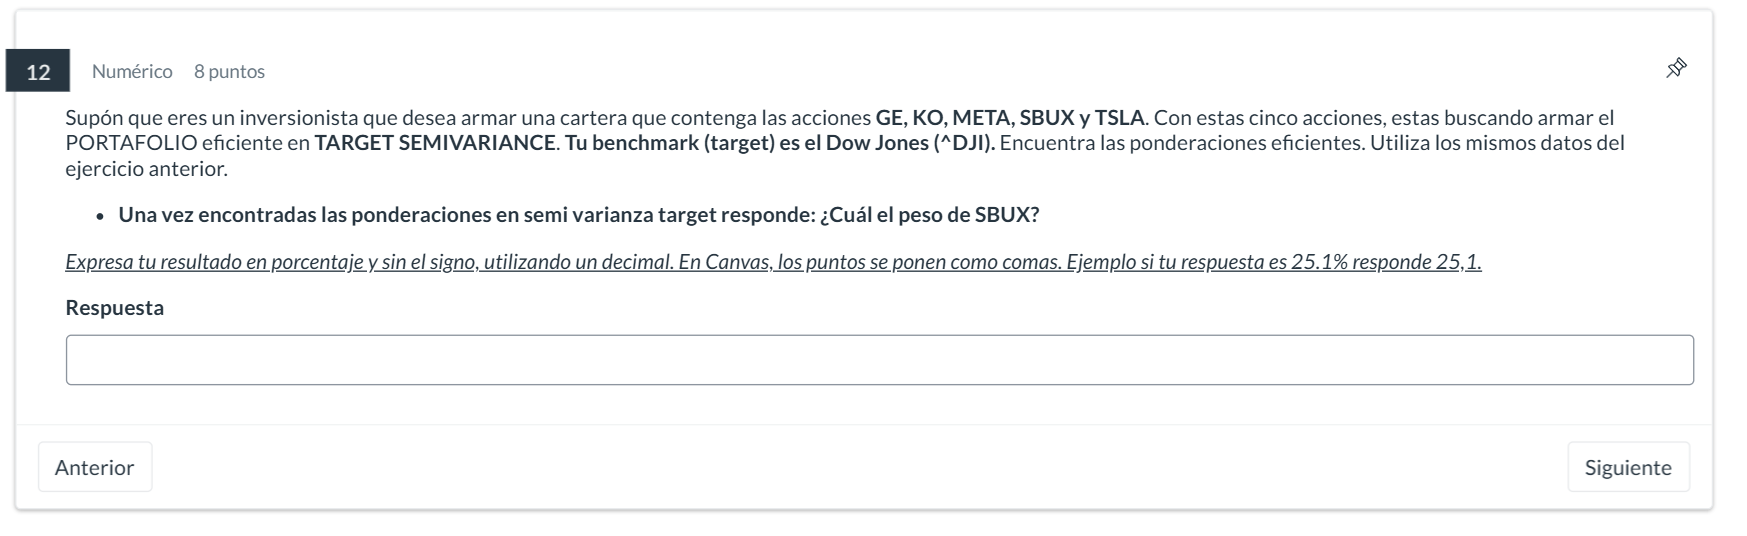

In [399]:
w_semivar= objetivo(rets, rets_b, corr)
w_semivar

{'GE': 0.0,
 'KO': 0.3813708793098004,
 'META': 0.23356351521348823,
 'SBUX': 0.3850656054767114,
 'TSLA': 5.204170427930421e-18}

---

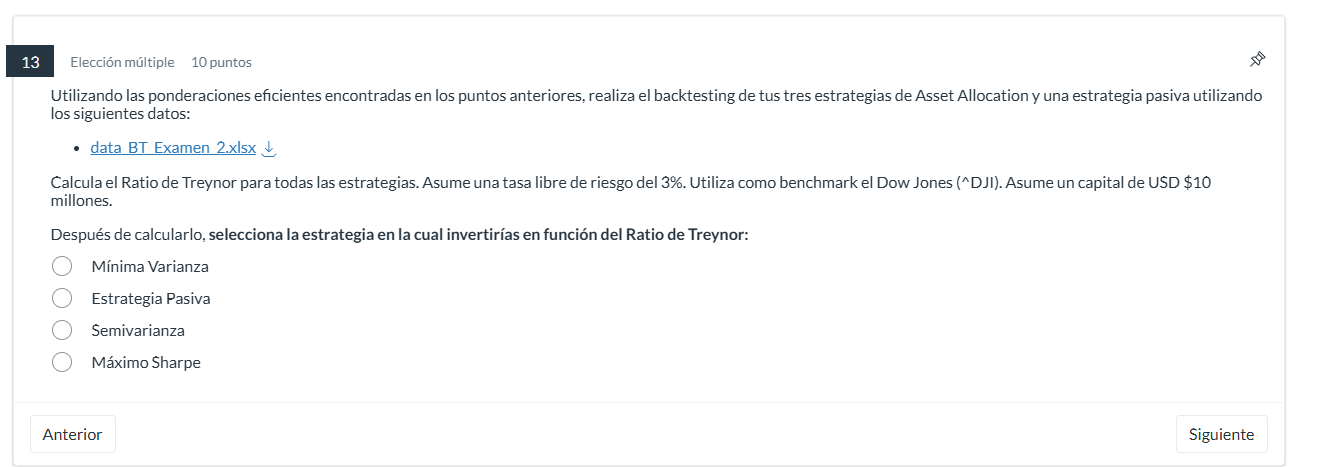

In [400]:
prices_bt = pd.read_excel('data_BT_Examen_2.xlsx', index_col=[0])
bt_prices = prices_bt[['GE', 'KO', 'META', 'SBUX', 'TSLA']]
benchmark = prices_bt[['^DJI']]

rets_bt = bt_prices.pct_change().dropna()
rets_b = benchmark.pct_change().dropna()


In [401]:
capital = 10000000

In [402]:
w_dict = {
    'min_var': w_minvar,
    'max_sharpe': w_maxsharpe,
    'semivar': w_semivar,
    'Benchmark': 1
}

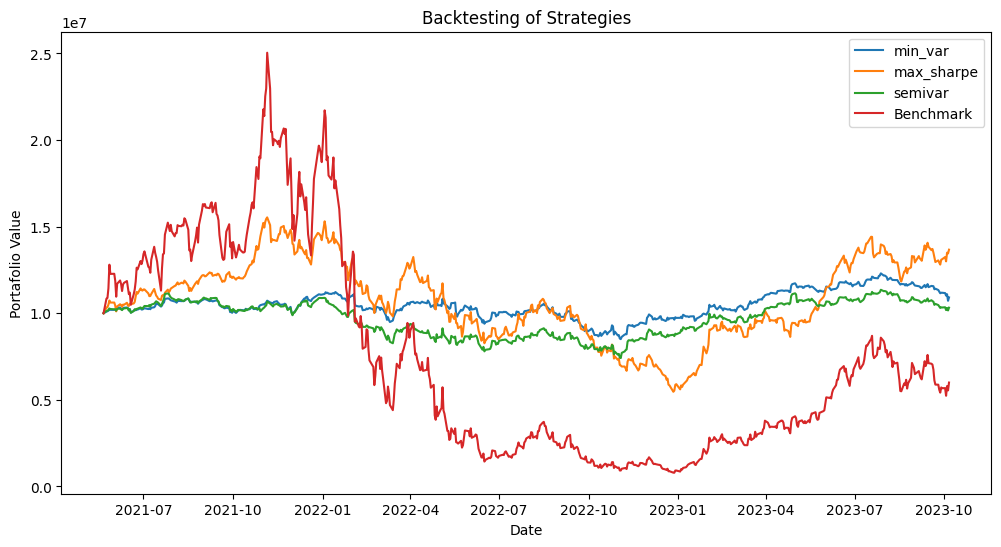

In [403]:
history = backtesting(bt_prices, benchmark, w_dict, capital)

In [404]:
metrics(history, 0.03)

,min_var,max_sharpe,semivar,Benchmark
Rendimiento,0.000214,0.000892,0.000148,0.002474
Volatilidad,0.011628,0.027177,0.013804,0.081037
Sharpe,-2.561699,-1.071054,-2.162515,-0.339670
Downside,0.008632,0.018422,0.009451,0.054888
Upside,0.007755,0.017896,0.009688,0.053225
Omega,0.898326,0.971466,1.024997,0.969705
Beta,0.113693,0.310191,0.147925,1.000000
Alpha,-0.026657,-0.020570,-0.025780,0.000000
Sortino,-3.450557,-1.580102,-3.158496,-0.501494
Treynor,-0.261988,-0.093839,-0.201805,-0.027526


----

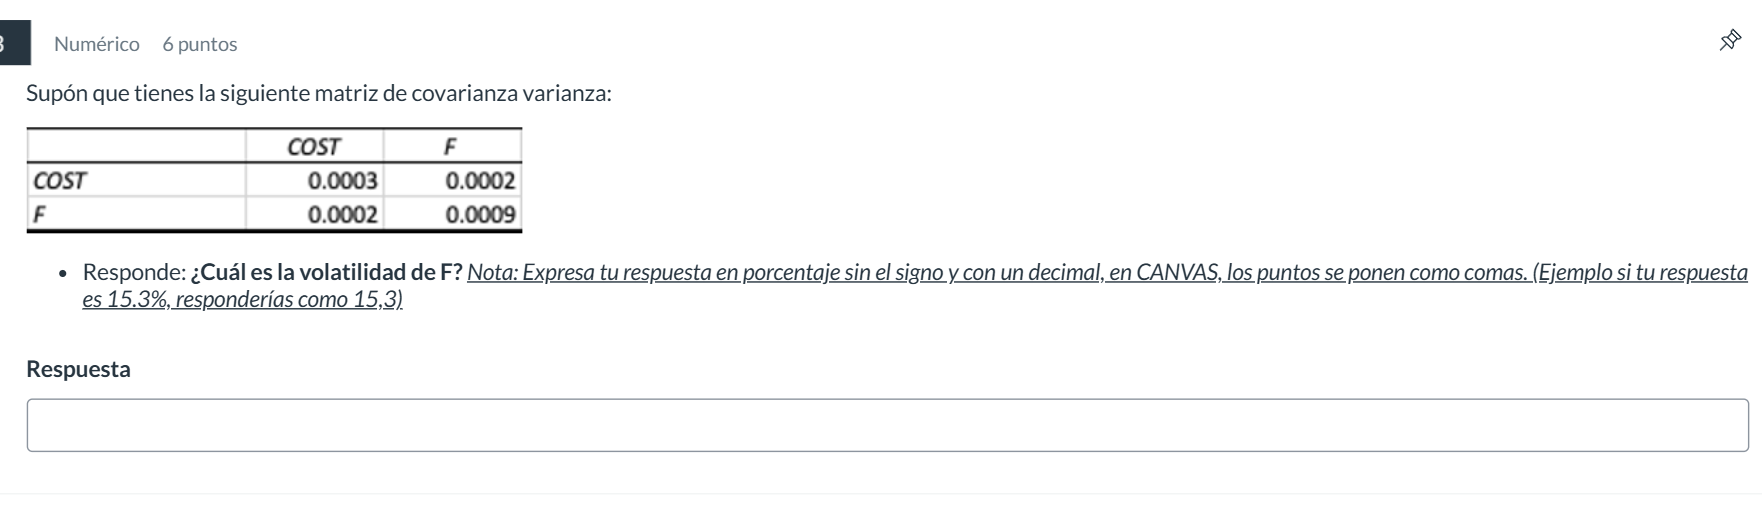

In [405]:
matriz = pd.DataFrame({
    'Cost': [0.0003, 0.0002],
    'F': [0.0002, 0.0009]
})



#### Volatilidad de F